# 9. Tutorial: Create iML1515 TRBA model

The generation of a TRBA model, a thermodynamics-constrained RBA model, can be achieved in a manner analogous to the generation of a TGECKO model. This process can be executed with minimal effort by reusing the XBA, RBA, and TFA configuration files and workflows that have been established in the preceding tutorials.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025

## Step 1: Initial setup

In [1]:
import os
import re
import time
from collections import defaultdict
import numpy as np
import pandas as pd
import cobra

from f2xba import XbaModel, TfaModel, RbaModel
from f2xba import RbaOptimization, RbaResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
baseline_model = 'iML1515_RBA'
target_model = 'iML1515_TRBA'
reference_cond = 'Glucose'

# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr )in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

# Metabolite concentrations to be fixed with a margin (Buckstein, 2008)
nt_concs_µmol_per_l = {
    'atp_c': 3560, 'adp_c': 116, 'datp_c': 181, 'ctp_c': 325, 'dctp_c': 184,
    'gtp_c': 1660, 'gdp_c': 203, 'dgtp_c': 92, 'utp_c': 667, 'udp_c': 54,
    'dttp_c': 256, 'ppgpp_c': 113, 'accoa_c': 1390}
factor = 2.0
metabolite_molar_concs = {sid: (µmol_per_l * 1e-6/factor, µmol_per_l*1e-6*factor) 
                          for sid, µmol_per_l in  nt_concs_µmol_per_l.items()}

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Create TRBA model

The generation of a TRBA model is initiated with an XbaModel that has been configured with the XBA configuration file, which was previously utilized for the RBA model. Subsequently, thermodynamics constraints are introduced using the TfaModel. Finally, the RBA configuration data is applied.

In [2]:
# Load GEM and extend the model with data from parameters file
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))

tfa_model = TfaModel(xba_model)
tfa_model.configure(os.path.join('data', f'{fba_model}_TFA_tfa_parameters.xlsx'))

rba_model = RbaModel(xba_model)
rba_model.configure(os.path.join('data', f'{baseline_model}_rba_parameters.xlsx'))
rba_model.export(os.path.join('SBML_models', f'{target_model}.xml'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
6 table(s) with parameters loaded from data/iML1515_RBA_xba_parameters.xlsx (Thu Feb 12 15:27:14 2026)
  22 gene product(s) removed from reactions (1494 gene products remaining)
  23 gene products added to the model (1517 total gene products)
  43 constraint ids added to the model (1920 total constraints)
  22 variable ids added to the model (2734 total variables)
   3 attributes on reaction instances updated
25 reactions with atom imbalances, e.g. [R_PUACGAMS, R_BIOMASS_Ec_iML1515_core_75p37M, R_BIOMASS_Ec_iML1515_WT_75p37M, ...], check XbaModel.atom_imbalances.
24 reactions with charge imbalances, e.g. [R_BIOMASS_Ec_iML1515_core_75p37M, R_BIOMASS_Ec_iML1515_WT_75p37M, R_FMETTRS, ...], check XbaModel.charge_imbalances.
extracting nucleotide sequence from data/ncbi/chromosome_U00096.3_fasta.txt
chromosome     : 4641652 nucleotides, 4308 mRNAs, 22 rRNAs, 86 tRNAs
extracting UniProt protein data from data/uniprot_

True

---
---
## Step 3. Load and optimize TRBA model (COBRApy)

It should be noted that the gurobipy interface, which will be utilized in the forthcoming examples, has been demonstrated to exhibit a substantial increase in processing speed.

In [3]:
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
rbam = cobra.io.read_sbml_model(fname)

# Load SBML model with RbaOptimization (required for optimization under COBRApy)
ro = RbaOptimization(fname, rbam)
sigma = ro.avg_enz_saturation
importer_km = ro.importer_km
print(f'average saturation level: {sigma}, importer Km: {importer_km} mmol/l')
all_genes = set(ro.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = ro.get_tx_metab_genes()
pm_genes = all_genes.difference(tx_genes.union(metab_genes))
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic, '
      f'({len(pm_genes)}) process machines')

# Set nucleotide concentrations (optional)
for sid, (lb, ub) in metabolite_molar_concs.items():
    rbam.reactions.get_by_id('V_LC_' + sid).bounds = (np.log10(lb), np.log10(ub))
print(f'{len(metabolite_molar_concs)} metabolite concentrations constrained')
print(f'Duration: {time.time()-start:.1f} s')

Set parameter Username
Set parameter LicenseID to value 2731209
Academic license - for non-commercial use only - expires 2026-10-31
SBML model loaded by sbmlxdf: SBML_models/iML1515_TRBA.xml (Thu Feb 12 16:48:48 2026)
Thermodynamic use variables (V_FU_xxx and V_RU_xxx) as binary
Thermodynamic constraints (C_F[FR]C_xxx, C_G[FR]C_xxx, C_SU_xxx) ≤ 0
3792 enzymes, 7 process machines, 1897 TD reaction constraints
RBA enzyme efficiency constraints configured (C_EF_xxx, C_ER_xxx) ≤ 0
average saturation level: 0.5, importer Km: 1.0 mmol/l
1611 genes: (492) transporter, (1025) metabolic, (94) process machines
13 metabolite concentrations constrained
Duration: 68.2 s


Acetate                  : pred gr: 0.414 h-1 vs. exp 0.290, diff:  0.124
Glycerol                 : pred gr: 0.402 h-1 vs. exp 0.470, diff: -0.068
Fructose                 : pred gr: 0.553 h-1 vs. exp 0.540, diff:  0.013
L-Malate                 : pred gr: 0.441 h-1 vs. exp 0.550, diff: -0.109
Glucose                  : pred gr: 0.646 h-1 vs. exp 0.660, diff: -0.014
Glucose 6-Phosphate      : pred gr: 0.597 h-1 vs. exp 0.780, diff: -0.183
Acetate                  : r² = 0.3685, p = 6.15e-113 (1112 proteins lin scale)
Glycerol                 : r² = 0.5317, p = 4.47e-185 (1112 proteins lin scale)
Fructose                 : r² = 0.6779, p = 2.40e-275 (1112 proteins lin scale)
Glucose                  : r² = 0.8505, p = 0.00e+00 (1112 proteins lin scale)
Acetate                  : r² = 0.4140, p = 8.21e-51 ( 423 proteins log scale)
Glycerol                 : r² = 0.5012, p = 2.53e-66 ( 428 proteins log scale)
Fructose                 : r² = 0.4760, p = 2.26e-59 ( 411 proteins log scale)


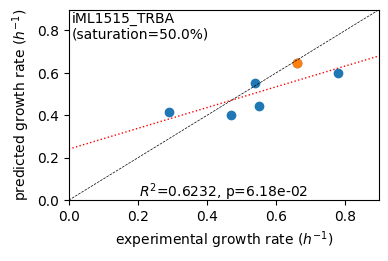

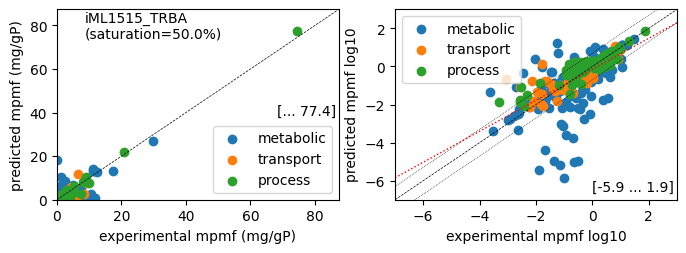

1 file(s) exported for "Load reaction data" into Escher maps
1 file(s) exported for "Load metabolite data" into Escher maps
Duration: 1340.7 s


In [4]:
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    rel_mmol_per_l =  (sigma / (1.0-min(sigma, .99))) * importer_km
    ex_sidx2mmol_per_l = {re.sub('EX_', '', ex_ridx): rel_mmol_per_l for ex_ridx in medium}
    ex_sidx2mmol_per_l['h_e'] = 100.0 * sigma   # H-symport reactions to be not constraint by main metabolite
    ro.medium = ex_sidx2mmol_per_l

    solution = ro.solve(gr_min=0.0, gr_max=1.2, bisection_tol=1e-3)
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
              f'diff: {gr - exp_grs[cond]:6.3f}')
    else:
        print(f'{cond:25s}: INFEASIBLE')
            
rr = RbaResults(ro, pred_results, df_mpmf)
df_fluxes = rr.collect_fluxes()
df_all_net_fluxes = rr.collect_fluxes(net=True)    
metabolic_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid) is None]
synthesis_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid)]
df_net_fluxes = df_all_net_fluxes.loc[metabolic_rids]

df_synt_fluxes = df_all_net_fluxes.loc[synthesis_rids]
df_protein_conc = rr.collect_protein_results('µmol_per_gDW')
df_proteins = rr.collect_protein_results('mg_per_gP')
df_enzyme_conc = rr.collect_enzyme_results('µmol_per_gDW')
df_rna_conc = rr.collect_rna_results('µmol_per_gDW')
df_occupancy = rr.collect_density_results()
df_capacity = rr.collect_density_results(capacity=True)
df_species_conc = rr.collect_species_conc()

rr.report_proteomics_correlation(scale='lin')
rr.report_proteomics_correlation(scale='log')
rr.report_protein_levels(reference_cond)
rr.plot_grs(exp_grs, highlight=reference_cond)
rr.plot_proteins(reference_cond)
rr.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', f'{target_model}_TRBA'))
rr.save_to_escher(df_species_conc[reference_cond], os.path.join('escher', f'{target_model}_TRBA'))
print(f'Duration: {time.time()-start:.1f} s')

In [5]:
# selected species concentrations
df_species_conc.loc[list(metabolite_molar_concs)].head()

,name,rank,mean mmol_per_l,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
sid,,,,,,,,,,
atp_c,ATP C10H12N5O13P3,1246,3.560000,2.757564,1.780000,7.1200,1.780000,1.780000,7.120,1.780000
adp_c,ADP C10H12N5O10P2,1301,0.174000,0.089853,0.232000,0.0580,0.232000,0.232000,0.058,0.232000
datp_c,DATP C10H12N5O12P3,1302,0.135750,0.110839,0.090500,0.0905,0.090500,0.090500,0.362,0.090500
ctp_c,CTP C9H12N3O14P3,1288,0.379685,0.209675,0.251642,0.6500,0.223186,0.251642,0.650,0.251642
dctp_c,DCTP C9H12N3O13P3,1306,0.092000,0.000000,0.092000,0.0920,0.092000,0.092000,0.092,0.092000


## (Optional) Track progress

In [6]:
import scipy
import numpy as np

number = 9
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = rr.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Feb 12 16:45:53 2026)
1 table(s) with parameters written to protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135981,0.201613,999,322
3,iML1515_predicted_GECKO,0.078803,0.268769,999,308
4,iML1515_manual_adjust_GECKO,0.205413,0.333470,999,308
5,iML1515_predicted_fit_GECKO,0.869850,0.549757,999,313
6,iML1515_RBA,0.855003,0.479941,1112,428
8,iML1515_TGECKO,0.869850,0.562074,999,317
9,iML1515_TRBA,0.850468,0.504015,1112,429


---
---
## (Alternative) gurobipy - model optimization

In [7]:
# Load TRBA model using gurobipy
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
ro = RbaOptimization(fname)
sigma = ro.avg_enz_saturation
importer_km = ro.importer_km
print(f'average saturation level: {sigma}, importer Km: {importer_km} mmol/l')
all_genes = set(ro.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = ro.get_tx_metab_genes()
pm_genes = all_genes.difference(tx_genes.union(metab_genes))
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic, '
      f'({len(pm_genes)}) process machines')

# Set nucleotide concentrations (optional)
orig_concs = ro.set_tfa_metab_concentrations(metabolite_molar_concs)
print(f'{len(orig_concs)} metabolite concentrations constrained')
print(f'Duration: {time.time()-start:.1f} s')

SBML model loaded by sbmlxdf: SBML_models/iML1515_TRBA.xml (Thu Feb 12 16:48:48 2026)
MILP Model of iML1515_TFA_RBA
18996 variables, 16363 constraints, 150325 non-zero matrix coefficients
3792 enzymes, 7 process machines, 1897 TD reaction constraints
RBA enzyme efficiency constraints configured (C_EF_xxx, C_ER_xxx) ≤ 0
average saturation level: 0.5, importer Km: 1.0 mmol/l
1611 genes: (492) transporter, (1025) metabolic, (94) process machines
13 metabolite concentrations constrained
Duration: 34.2 s


Acetate                  : pred gr: 0.414 h-1 vs. exp 0.290, diff:  0.124
Glycerol                 : pred gr: 0.402 h-1 vs. exp 0.470, diff: -0.068
Fructose                 : pred gr: 0.553 h-1 vs. exp 0.540, diff:  0.013
L-Malate                 : pred gr: 0.441 h-1 vs. exp 0.550, diff: -0.109
Glucose                  : pred gr: 0.646 h-1 vs. exp 0.660, diff: -0.014
Glucose 6-Phosphate      : pred gr: 0.597 h-1 vs. exp 0.780, diff: -0.183
Acetate                  : r² = 0.3647, p = 1.85e-111 (1112 proteins lin scale)
Glycerol                 : r² = 0.5304, p = 2.10e-184 (1112 proteins lin scale)
Fructose                 : r² = 0.6775, p = 4.84e-275 (1112 proteins lin scale)
Glucose                  : r² = 0.8505, p = 0.00e+00 (1112 proteins lin scale)
Acetate                  : r² = 0.4254, p = 1.40e-53 ( 431 proteins log scale)
Glycerol                 : r² = 0.5002, p = 3.04e-65 ( 422 proteins log scale)
Fructose                 : r² = 0.4623, p = 1.79e-57 ( 414 proteins log scale)


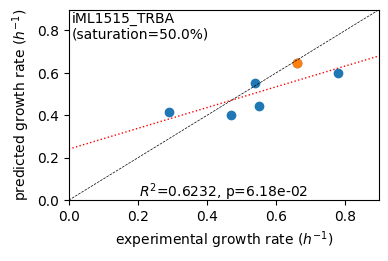

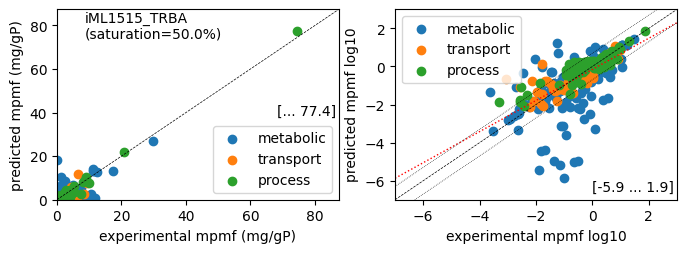

1 file(s) exported for "Load reaction data" into Escher maps
1 file(s) exported for "Load metabolite data" into Escher maps
Duration: 173.9 s


In [8]:
# Optimize model using gurobipy and analyze results
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    rel_mmol_per_l =  (sigma / (1.0-min(sigma, .99))) * importer_km
    ex_sidx2mmol_per_l = {re.sub('EX_', '', ex_ridx): rel_mmol_per_l for ex_ridx in medium}
    ex_sidx2mmol_per_l['h_e'] = 100.0 * sigma   # H-symport reactions to be not constraint by main metabolite
    ro.medium = ex_sidx2mmol_per_l

    solution = ro.solve(gr_min=0.0, gr_max=1.2, bisection_tol=1e-3)
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
              f'diff: {gr - exp_grs[cond]:6.3f}')
    else:
        print(f'{cond:25s}: INFEASIBLE')
            
rr = RbaResults(ro, pred_results, df_mpmf)
df_fluxes = rr.collect_fluxes()
df_all_net_fluxes = rr.collect_fluxes(net=True)    
metabolic_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid) is None]
synthesis_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid)]
df_net_fluxes = df_all_net_fluxes.loc[metabolic_rids]

df_synt_fluxes = df_all_net_fluxes.loc[synthesis_rids]
df_protein_conc = rr.collect_protein_results('µmol_per_gDW')
df_proteins = rr.collect_protein_results('mg_per_gP')
df_enzyme_conc = rr.collect_enzyme_results('µmol_per_gDW')
df_rna_conc = rr.collect_rna_results('µmol_per_gDW')
df_occupancy = rr.collect_density_results()
df_capacity = rr.collect_density_results(capacity=True)
df_species_conc = rr.collect_species_conc()

rr.report_proteomics_correlation(scale='lin')
rr.report_proteomics_correlation(scale='log')
rr.report_protein_levels(reference_cond)
rr.plot_grs(exp_grs, highlight=reference_cond)
rr.plot_proteins(reference_cond)
rr.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))
rr.save_to_escher(df_species_conc[reference_cond], os.path.join('escher', target_model))
print(f'Duration: {time.time()-start:.1f} s')